In [ ]:
# Not updated.
# Use the Pluto notebook instead.

In [1]:
import CairoMakie
import CSV
import HDF5
import FASTX
import Infernal
import KernelDensity
import Makie
import RestrictedBoltzmannMachines as RBMs
import Rfam
import SamApp2024
import StatsBase
import PythonPlot
import Logomaker
using BioSequences: LongRNA
using DataFrames: DataFrame
using Distributions: Gamma
using Distributions: logpdf
using Distributions: pdf
using Distributions: Poisson
using LinearAlgebra: Diagonal
using LinearAlgebra: eigen
using Makie: @L_str
using NaNStatistics: nansum
using ProgressMeter: @showprogress
using Random: bitrand
using Statistics: cor
using Statistics: mean
using StatsBase: countmap

In [2]:
# CM model from Rfam (this has the noisy floor!)
Rfam_cm = Infernal.cmfetch(Rfam.cm(), "RF00162");

In [3]:
# trimmed (no inserts) aligned fasta
RF00162_hits_afa = Infernal.cmalign(Rfam_cm.out, Rfam.fasta_file("RF00162"); matchonly=true, outformat="AFA");
# these are already aligned and without inserts
RF00162_hits_sequences = FASTX.sequence.(FASTX.FASTA.Reader(open(RF00162_hits_afa.out)));
@assert only(unique(length.(RF00162_hits_sequences))) == 108
RF00162_hits_sequences = LongRNA{4}.(RF00162_hits_sequences);

# Plots

In [4]:
# APC-corrected contact map
Cmap = SamApp.effective_contacts(SamApp.rbm2022(), SamApp.onehot(RF00162_hits_sequences));

# zero-out diagonal
for i in axes(Cmap, 1)
    Cmap[i,i] = 0
end

In [5]:
plotted_matrix = copy(Cmap)
for i = axes(plotted_matrix, 1), j = axes(plotted_matrix, 2)
    if i < j
        plotted_matrix[i,j] = Cmap[i,j]
    else
        plotted_matrix[i,j] = 0
    end
end

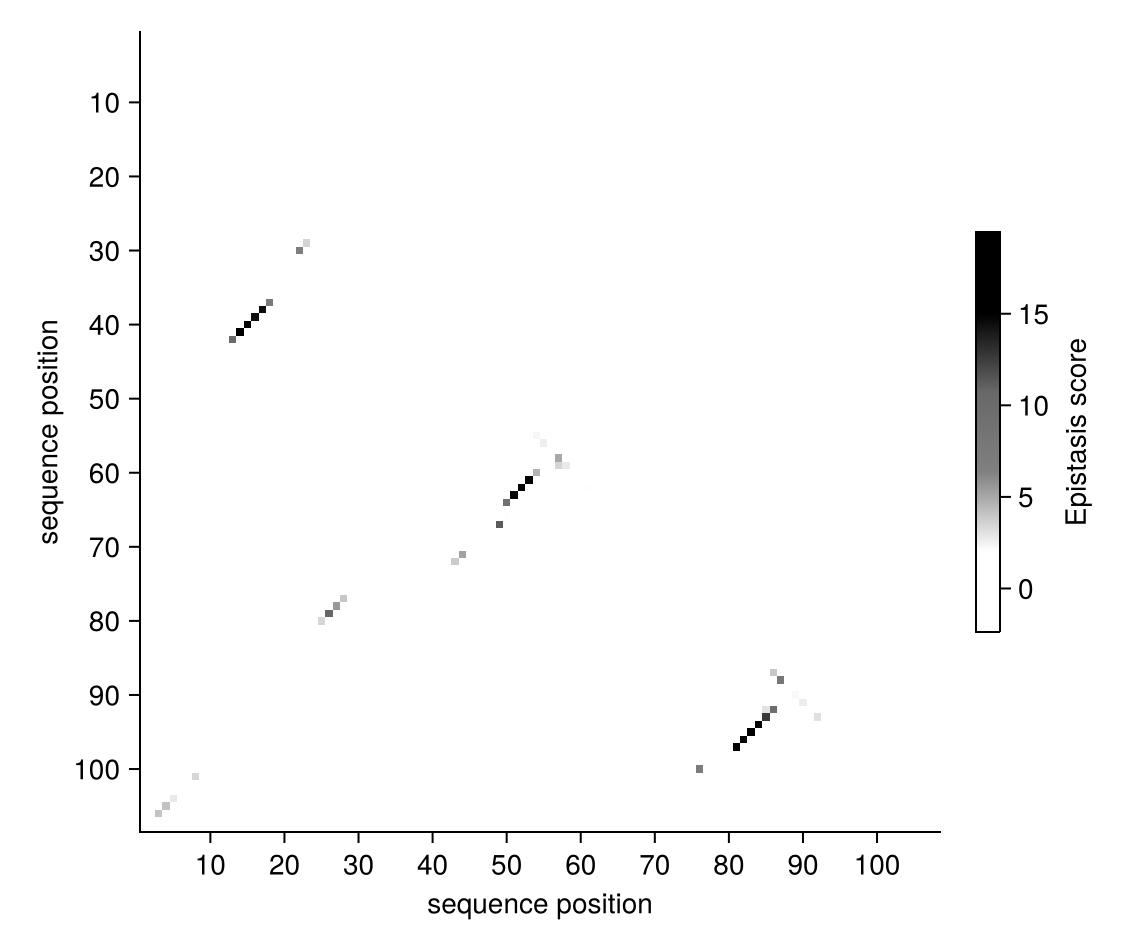

In [6]:
fig = Makie.Figure()
ax = Makie.Axis(fig[1,1], yreversed=true, width=400, height=400, xticks=0:10:size(Cmap,1), yticks=0:10:size(Cmap,2), xlabel="sequence position", ylabel="sequence position")
hm = Makie.heatmap!(ax, plotted_matrix, colormap=["white", "white", "gray", "dimgray", "black", "black"])
Makie.hidespines!(ax, :t, :r)
Makie.Colorbar(fig[1,2], hm, height=200, label="Epistasis score")
Makie.resize_to_layout!(fig)
Makie.save("Figures/Contacts bw.pdf", fig)
fig